In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [27]:
br = yf.download(tickers='BRLUSD=X', period='1y', interval='1h')

[*********************100%***********************]  1 of 1 completed


In [28]:
#gold = yf.download(tickers='GC=F', period='2y', interval='1h')
#br = yf.download(tickers='BRLUSD=X', period='2y', interval='1h')
#silver = yf.download(tickers='SI=F', period='2y', interval='1h')
eur = yf.download(tickers='EURUSD=X', period='1y', interval='1h')
xrp = yf.download(tickers='XRP-USD', period='1y', interval='1h')
xlm = yf.download(tickers='XLM-USD', period='1y', interval='1h')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
solana = yf.download(tickers='SOL-USD', period='1y', interval='1h')
btc = yf.download(tickers='BTC-USD', period='1y', interval='1h')
#eth = yf.download(tickers='ETH-USD', period='2y', interval='1h')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [30]:
eth = yf.download(tickers='ETH-USD', period='1y', interval='1h')

[*********************100%***********************]  1 of 1 completed


In [31]:
master = pd.concat([br['Close'], eur['Close'], xrp['Close']
                    , xlm['Close'], solana['Close'], btc['Close'], eth['Close']], axis=1)
master.columns = ['br', 'eur', 'xrp', 'xlm', 'solana', 'btc', 'eth']


<AxesSubplot:ylabel='Datetime'>

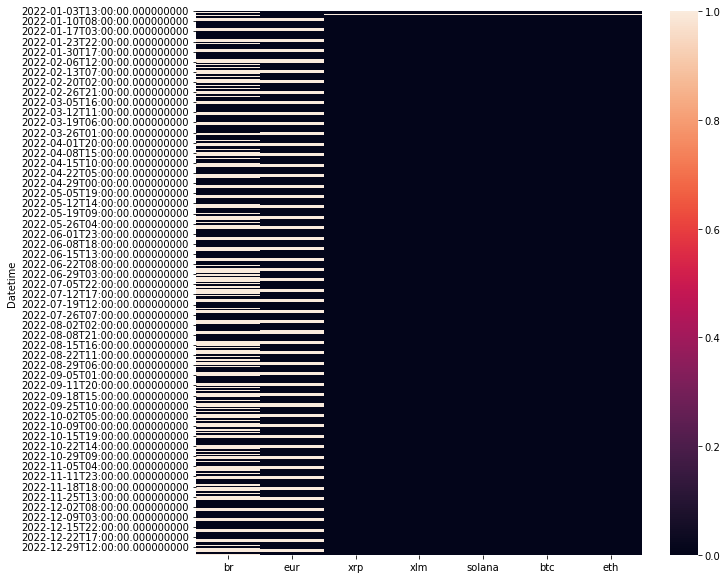

In [32]:
plt.figure(figsize=(10,10))
sns.heatmap(master.isna())

In [33]:
# Keep last 2 years
data = master.loc[(master.index.astype('str').str.startswith('2022')) |
                  (master.index.astype('str').str.startswith('2023'))][['xrp', 'xlm', 'solana', 'btc', 'eth']]

In [34]:
# Conversion to 4hrs
data_4h = data[(data.index.astype('str').str.slice(11,13).astype('int') == 1) | (data.index.astype('str').str.slice(11,13).astype('int') == 5)
    | (data.index.astype('str').str.slice(11,13).astype('int') == 9) | (data.index.astype('str').str.slice(11,13).astype('int') == 13) |
    (data.index.astype('str').str.slice(11,13).astype('int') == 17) | (data.index.astype('str').str.slice(11,13).astype('int') == 21)]

In [35]:
stationary = data_4h.pct_change(1)
series_names = stationary.columns

lag_1 = stationary.shift(1)
lag_2 = stationary.shift(2)
lag_3 = stationary.shift(3)
lag_4 = stationary.shift(4)
lag_5 = stationary.shift(5)
lag_6 = stationary.shift(6)

for i in range(1,7):
    exec(f"lag_{i}.columns = series_names + '_lag{i}'")
    
final = pd.concat([stationary, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6], axis=1)
final.dropna(axis=0, inplace=True)

In [36]:
y = final["xrp"] #
x = final.iloc[:,5:] #past data

In [37]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import max_error, make_scorer
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

model = xgb.XGBRegressor(n_jobs=1, tree_method='hist', random_state=0)

def BSCV(K, n_iter, model):
    
    #Cost metric
    def cost_metric(y_true,y_predicted):
        cost_metric = alpha*matthews_corrcoef(y_true,y_predicted) + (1-alpha)*sensitivity(y_true,y_predicted)
        return cost_metric

    cv = TimeSeriesSplit(gap=0, n_splits=K, test_size=100)
  
    param_grid = {
                #"colsample_bytree": Real(0, 1, prior='uniform'),
                #"colsample_bylevel": Real(0, 1, prior='uniform'),
                #"colsample_bynode": Real(0, 1, prior='uniform'),
                "lambda": (1e-2, 1e+2, 'log-uniform'),
                "alpha": (1e-2, 1e+2, 'log-uniform'),
                #"gamma": Real(0.1, 5, prior='uniform'),
                #"tree_method": ['hist'],
                #"XGBoost__sketch_eps": [0.03],
                #"XGBoost__scale_pos_weight": [cost_weight, cost_weight*3, cost_weight*4],
                #"process_type": ['default'],
                "grow_policy": Categorical(['depthwise', 'lossguide']),
                #"eval_metric": Categorical(['auc', 'logloss']),
                #"max_leaves": Integer(0,5),
                #"max_bin": [300],
                "learning_rate": Real(0.2, 0.8, prior='uniform'),
                "max_depth": Integer(9,20), 
                "n_estimators": Integer(0,100), # default 100
                #"subsample": Real(0.9, 1, prior='uniform'),
                "min_child_weight": Integer(10,20),
                "max_delta_step": Integer(1,20)
                }

    search_ddnn = BayesSearchCV(random_state=0, estimator=model, search_spaces=param_grid, 
                        scoring=make_scorer(max_error, greater_is_better=False), cv=cv, n_jobs=-1, verbose=10,
                        n_iter=n_iter, return_train_score=True,
                        optimizer_kwargs={'base_estimator': 'GP', 'initial_point_generator': 'lhs'},
                        n_points=5, pre_dispatch='1*n_jobs')
    return search_ddnn

res = BSCV(K=10, n_iter=50, model=model).fit(x,y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [38]:
import pickle
pickle.dump(res.best_estimator_, open('model.pkl', 'wb')) #Save trained model
pickled_model = pickle.load(open('model.pkl', 'rb'))

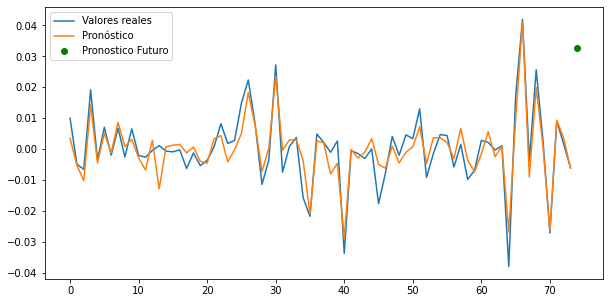

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y.values[-74:], label='Valores reales')
plt.plot(pickled_model.predict(x)[-74:], label='Pronóstico')
plt.scatter(x=74,
            y=pickled_model.predict(pd.concat([final.iloc[-1:,0:5], x.iloc[-1:,0:-5]], axis=1).values),
           color='green', label='Pronostico Futuro')
plt.legend()

In [40]:
print('------------------------------------------------------------------')
print('Forecast serie:', y.name)
print('------------------------------------------------------------------')

print('Actual data:', final.index[-1])

print(data_4h['xrp'].iloc[-1])

print('Past forecast:', (data_4h.iloc[-2:-1,0].values*(1+pickled_model.predict(x.iloc[-1:,:]))).item())

print('------------------------------------------------------------------')
print('Forecast data (4 hours ahead):', pd.Timestamp(data_4h.index[-1].asm8 + int(1.44e13)))

print('Predicted change(%):', np.round(pickled_model.predict(pd.concat([final.iloc[-1:,0:5], x.iloc[-1:,0:-5]], axis=1).values).item()*100,2))
print('------------------------------------------------------------------')

print('4 hours ahead forecast:')
print(data_4h['xrp'].iloc[-1]*(1+pickled_model.predict(pd.concat([final.iloc[-1:,0:5], x.iloc[-1:,0:-5]], axis=1).values)).item())


------------------------------------------------------------------
Forecast serie: xrp
------------------------------------------------------------------
Actual data: 2023-01-03 13:00:00
0.3458046019077301
Past forecast: 0.3457608891613475
------------------------------------------------------------------
Forecast data (4 hours ahead): 2023-01-03 17:00:00
Predicted change(%): 3.28
------------------------------------------------------------------
4 hours ahead forecast:
0.35713572482349676


<AxesSubplot:xlabel='imp', ylabel='f'>

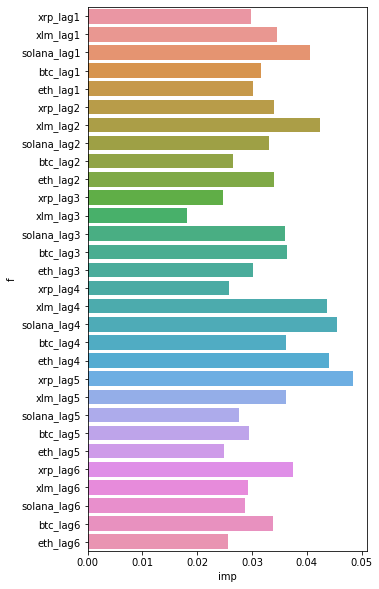

In [41]:
plt.figure(figsize=(5,10))
sns.barplot(y=pd.DataFrame(zip(x.columns.values,pickled_model.feature_importances_), columns=['f', 'imp'])['f'], x=pd.DataFrame(zip(x.columns.values,pickled_model.feature_importances_), columns=['f', 'imp'])['imp'])

In [42]:
data_4h.iloc[-2:-1,0]

Datetime
2023-01-03 09:00:00    0.347903
Freq: 4H, Name: xrp, dtype: float64